In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

In [12]:
daily_demand_complete = pd.read_csv(r"C:\Users\ramak\OneDrive\Documents\projects\daily_demand_complete.csv", parse_dates=['order_date'])
daily_demand_complete.drop('Unnamed: 0', axis = 1, inplace = True)
daily_demand_complete.head()

,order_date,demand
0,2016-09-15,1.0
1,2016-09-16,0.0
2,2016-09-17,0.0
3,2016-09-18,0.0
4,2016-09-19,0.0


#### The decomposition revealed a clear weekly seasonal pattern, indicating that customer ordering behavior is strongly influenced by day-of-week effects.

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

daily_demand_complete = daily_demand_complete.set_index('order_date')
decomp_weekly = seasonal_decompose(daily_demand_complete, model = "additive", period = 7)
decomp_weekly

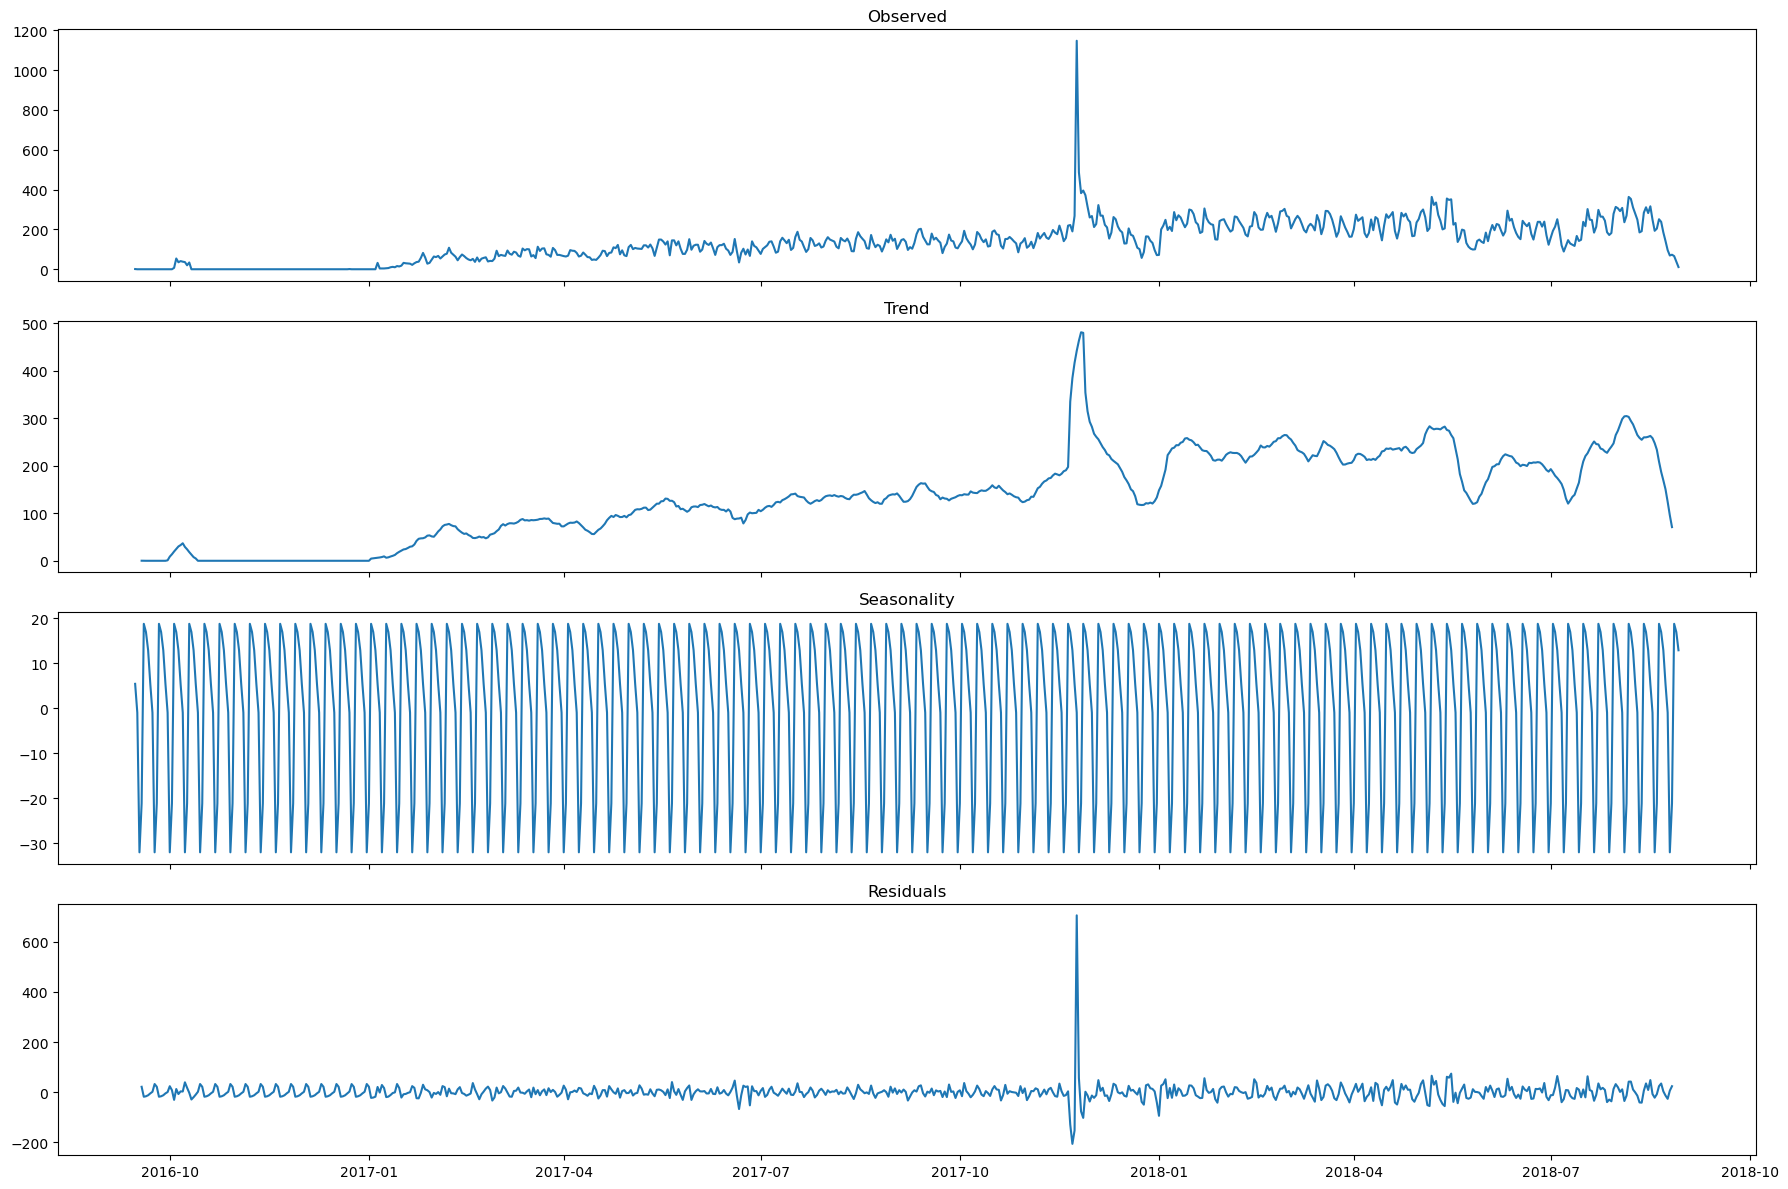

In [16]:
fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharex=True)

axes[0].plot(decomp_weekly.observed)
axes[0].set_title("Observed")

axes[1].plot(decomp_weekly.trend)
axes[1].set_title("Trend")

axes[2].plot(decomp_weekly.seasonal)
axes[2].set_title("Seasonality")

axes[3].plot(decomp_weekly.resid)
axes[3].set_title("Residuals")

plt.tight_layout()
plt.show()


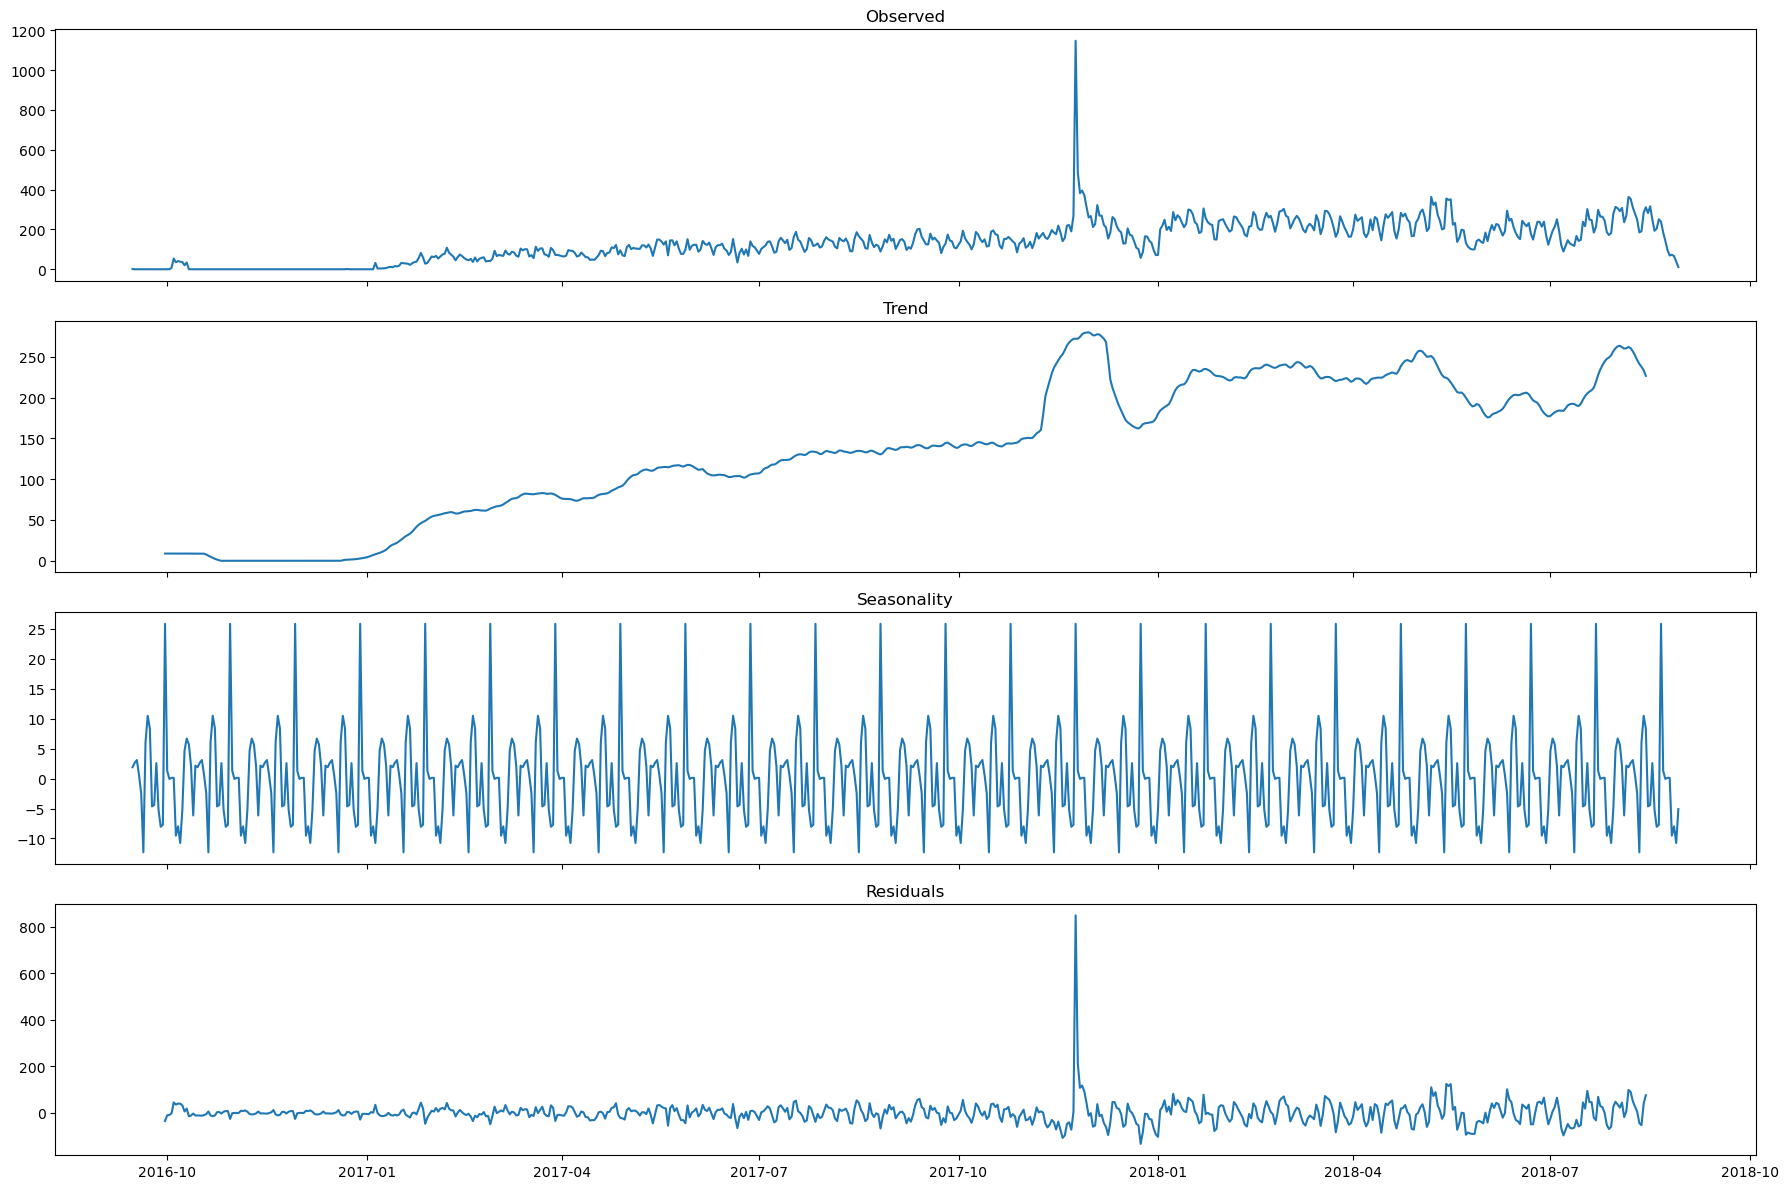

In [17]:
decomp_monthly = seasonal_decompose(daily_demand_complete, model = "additive", period = 30)

fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharex=True)

axes[0].plot(decomp_monthly.observed)
axes[0].set_title("Observed")

axes[1].plot(decomp_monthly.trend)
axes[1].set_title("Trend")

axes[2].plot(decomp_monthly.seasonal)
axes[2].set_title("Seasonality")

axes[3].plot(decomp_monthly.resid)
axes[3].set_title("Residuals")

plt.tight_layout()
plt.show()


#### Performed Augmented Dickey–Fuller (ADF) test on daily order demand to assess stationarity. The test indicated that the series is non-stationary, confirming the presence of trend and seasonality observed during decomposition.

In [18]:
from statsmodels.tsa.stattools import adfuller

def DickeyFullerTest(data):
    ad_result = adfuller(data)
    print("ADF Statistic: ", ad_result[0])
    print("P-Value: ", ad_result[1])
    if ad_result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is not stationary")

In [19]:
DickeyFullerTest(daily_demand_complete)

ADF Statistic:  -2.4588122583082166
P-Value:  0.12581998543053624
Data is not stationary


#### Applied first-order differencing to daily demand series to remove trend and achieve stationarity. After differencing, the ADF test confirmed stationarity, indicating suitability for ARIMA-based modeling.

In [20]:
first_order_difference = daily_demand_complete - daily_demand_complete.shift(1)
first_order_difference = first_order_difference.dropna()
first_order_difference

,demand
order_date,
2016-09-16,-1.0
2016-09-17,0.0
2016-09-18,0.0
2016-09-19,0.0
2016-09-20,0.0
...,...
2018-08-25,-27.0
2018-08-26,4.0
2018-08-27,-7.0


In [21]:
DickeyFullerTest(first_order_difference)

ADF Statistic:  -6.554187901937972
P-Value:  8.699256015051079e-09
Data is stationary


#### Analyzed ACF and PACF plots of the differenced demand series to identify appropriate ARIMA parameters. Significant spikes in early lags guided the selection of autoregressive (p) and moving average (q) orders.

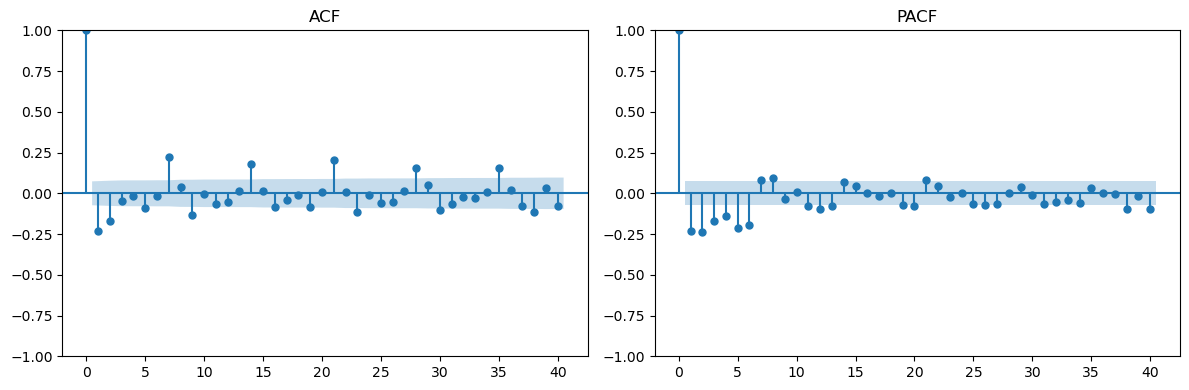

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize = (12, 4))

plot_acf(first_order_difference, ax = ax[0], lags = 40)
plot_pacf(first_order_difference, ax = ax[1], lags = 40)

ax[0].set_title("ACF")
ax[1].set_title('PACF')

plt.tight_layout()
plt.show()

#### Split the daily demand time series into training and testing sets using a chronological 80/20 split. The training set contains historical data, while the test set represents future unseen demand to evaluate forecasting performance

In [28]:
from sklearn.model_selection import train_test_split
daily_demand_complete = daily_demand_complete['demand']
# Set shuffle=False to keep the temporal order intact
train, test = train_test_split(daily_demand_complete, test_size=0.2, shuffle=False)

In [29]:
train

order_date
2016-09-15      1.0
2016-09-16      0.0
2016-09-17      0.0
2016-09-18      0.0
2016-09-19      0.0
              ...  
2018-04-04    252.0
2018-04-05    261.0
2018-04-06    181.0
2018-04-07    161.0
2018-04-08    183.0
Name: demand, Length: 571, dtype: float64

In [30]:
test

order_date
2018-04-09    250.0
2018-04-10    196.0
2018-04-11    262.0
2018-04-12    253.0
2018-04-13    197.0
              ...  
2018-08-25     69.0
2018-08-26     73.0
2018-08-27     66.0
2018-08-28     39.0
2018-08-29     11.0
Name: demand, Length: 143, dtype: float64

#### Identified outliers in the training data were treated using a 7-day rolling median replacement strategy to reduce the impact of extreme spikes while preserving temporal continuity and seasonality

In [31]:
# 1. Calculate the 7-day rolling median (the "patch" data)
rolling_median = train.rolling(window=7, center=True).median().ffill().bfill()

# 2. Use your existing IQR bounds to find the outliers
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 3. Replace only the outliers with the rolling median values
# If value is an outlier, use rolling_median; else, keep original train value
train_filled = pd.Series(
    np.where(
        (train < lower_bound) | (train > upper_bound), 
        rolling_median, 
        train
    ), 
    index=train.index
)

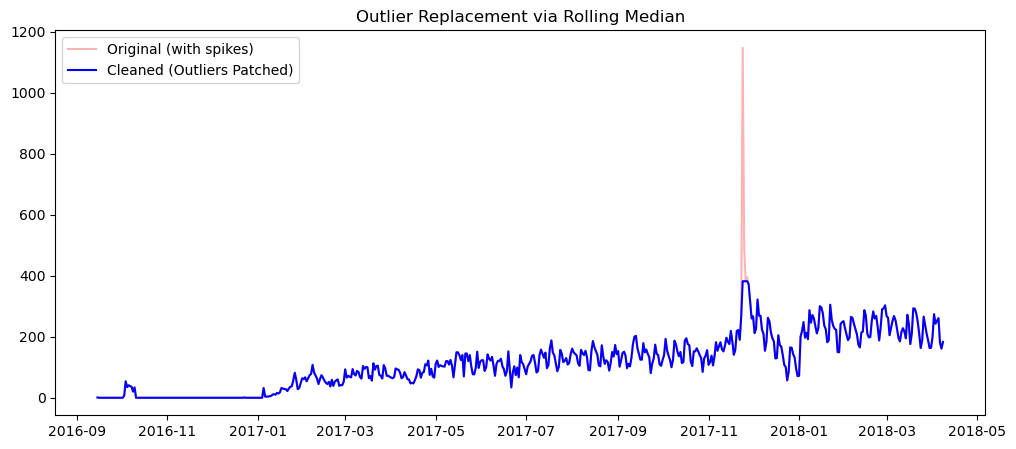

Number of points patched: 5


In [32]:
plt.figure(figsize=(12, 5))
plt.plot(train, label='Original (with spikes)', color='red', alpha=0.3)
plt.plot(train_filled, label='Cleaned (Outliers Patched)', color='blue', linewidth=1.5)
plt.legend()
plt.title("Outlier Replacement via Rolling Median")
plt.show()

print(f"Number of points patched: {((train < lower_bound) | (train > upper_bound)).sum()}")

In [33]:
DickeyFullerTest(train_filled)

ADF Statistic:  -1.333369288931665
P-Value:  0.6137709681476631
Data is not stationary


In [34]:
first_order_difference = train_filled - train_filled.shift(1)
first_order_difference = first_order_difference.dropna()
first_order_difference

order_date
2016-09-16    -1.0
2016-09-17     0.0
2016-09-18     0.0
2016-09-19     0.0
2016-09-20     0.0
              ... 
2018-04-04     9.0
2018-04-05     9.0
2018-04-06   -80.0
2018-04-07   -20.0
2018-04-08    22.0
Length: 570, dtype: float64

In [35]:
DickeyFullerTest(first_order_difference)

ADF Statistic:  -6.784913079782735
P-Value:  2.4460478636401905e-09
Data is stationary


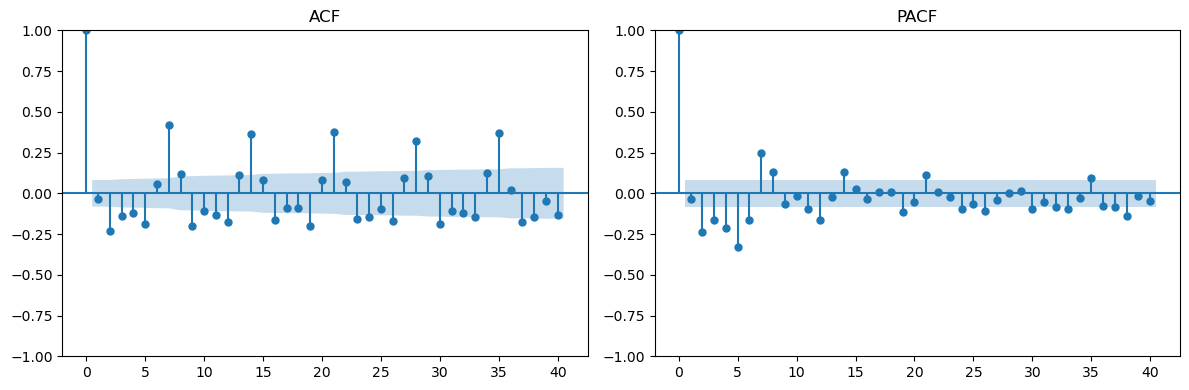

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize = (12, 4))

plot_acf(first_order_difference, ax = ax[0], lags = 40)
plot_pacf(first_order_difference, ax = ax[1], lags = 40)

ax[0].set_title("ACF")
ax[1].set_title('PACF')

plt.tight_layout()
plt.show()

In [38]:
train_filled.to_csv(r"C:\Users\ramak\OneDrive\Documents\projects\demand_train.csv")
test.to_csv(r"C:\Users\ramak\OneDrive\Documents\projects\demand.test.csv")